*name:* Charlie Belinky

# Introduction

The source for my dataset is: https://www.kaggle.com/andrewmvd/doom-crossing?select=doom_crossing_dataset.csv. This dataset contains 1597 image posts extracted from both r/doom and r/animalcrossing, including metadata. Images and metadata come from the source reddit post including post title, upvotes, downvotes, time of post creation, url, etc. 

The target is the actual image. I plan to use this dataset to train models that are able to differentiate an image from the *Animal Crossing* and *Doom* subreddits.

In [1]:
import sys

!$sys.executable -m pip install tensorflow

You should consider upgrading via the 'C:\Users\Charlie\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
plt.style.use('seaborn')
import numpy as np # linear algebra
import os # accessing directory structure
import cv2
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pathlib

from scipy import ndimage

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

import seaborn as sns

import random

# Setup

In [6]:
ac = pd.read_csv("archive/animal_crossing_dataset.csv")
doom = pd.read_csv("archive/doom_crossing_dataset.csv")
data = pd.concat([ac, doom])
data.shape

(1596, 11)

In [7]:
ac_filePath = "archive/images/animal_crossing"
doom_filePath = "archive/images/doom"

In [7]:
ac.head()

subreddit      id                                              title  \
0  AnimalCrossing  g6ra3l  Elijah Wood visits a fan's island after seeing...   
1  AnimalCrossing  gp8bts            Amazing idea my girlfriend came up with   
2  AnimalCrossing  g8jju6                     I just... really like Blathers   
3  AnimalCrossing  gempba                   I couldn't let my boy down. [OC]   
4  AnimalCrossing  fuv26r  My island is called Ravioli and I just finishe...   

      ups  downs  upvote_ratio  total_awards_received  num_comments  \
0  103447      0          0.96                      7          1527   
1   85186      0          0.93                     16          1175   
2   81436      0          0.95                     28           903   
3   72708      0          0.96                     24           522   
4   70357      0          0.96                      9           563   

    created_utc                                  url           filename  
0  1.587664e+09  https://i.redd.it/yjrafuspulu41.png  yjrafuspulu41.png  
1  1.590253e+09  https://i.redd.it/2ehmq0fjpj051.jpg  2ehmq0fjpj051.jpg  
2  1.587926e+09  https://i.redd.it/a2vvzng7g7v41.jpg  a2vvzng7g7v41.jpg  
3  1.588781e+09  https://i.redd.it/t88z1sn736x41.jpg  t88z1sn736x41.jpg  
4  1.586012e+09  https://i.redd.it/176wf6duetq41.jpg  176wf6duetq41.jpg

In [8]:
doom.head()

subreddit      id                                              title    ups  \
0      Doom  gtli3b                                And always remember  39007   
1      Doom  fnj4e5                               Remember to have fun  30071   
2      Doom  gemj1h  Can we please send our appreciacion to the lea...  27189   
3      Doom  fzhpqt  This painting from this subreddit a year ago, ...  22948   
4      Doom  g4v23f  Bethesda, you can still do the right thing her...  19896   

   downs  upvote_ratio  total_awards_received  num_comments   created_utc  \
0      0          0.94                      1           531  1.590872e+09   
1      0          0.96                     10          1158  1.584966e+09   
2      0          0.92                      5           965  1.588780e+09   
3      0          0.97                      1           296  1.586636e+09   
4      0          0.96                     34           956  1.587397e+09   

                                   url           filename  
0  https://i.redd.it/ksn72cinsy151.jpg  ksn72cinsy151.jpg  
1  https://i.redd.it/ik4d2mpi1fo41.jpg  ik4d2mpi1fo41.jpg  
2  https://i.redd.it/y5pddy7h16x41.jpg  y5pddy7h16x41.jpg  
3  https://i.redd.it/jrk0eogay8s41.jpg  jrk0eogay8s41.jpg  
4  https://i.redd.it/7c3lyx28tzt41.jpg  7c3lyx28tzt41.jpg

In [22]:
ac.sort_values('ups', ascending=False).head(10)[['title','ups']]

title     ups
0  Elijah Wood visits a fan's island after seeing...  103447
1            Amazing idea my girlfriend came up with   85186
2                     I just... really like Blathers   81436
3                   I couldn't let my boy down. [OC]   72708
4  My island is called Ravioli and I just finishe...   70357
5                           Made a nice-looking park   70254
6                    Animal Crossing, but a Concept.   69982
7                             Welcome to my onlyfans   69222
8                                                💛💛💛   68880
9  I regret giving Beardo the towel wrap every si...   68510

In [23]:
doom.sort_values('ups', ascending=False).head(10)[['title','ups']]

title    ups
0                                And always remember  39007
1                               Remember to have fun  30071
2  Can we please send our appreciacion to the lea...  27189
3  This painting from this subreddit a year ago, ...  22948
4  Bethesda, you can still do the right thing her...  19896
5  Found on one of the OST comments. Thought it b...  18220
6  I made a skin for the Slayer based on my favou...  17016
7         At least my hands are getting a workout...  16762
8                    Rip and Tear, until it is done.  16299
9                     Front Page of IGN This Morning  15074

In [9]:
ac_fileNames = list(ac.filename.values)
doom_fileNames = list(doom.filename.values)

In [10]:
random.seed(123)
ac_subset = random.sample(ac_fileNames, 25)
doom_subset = random.sample(doom_fileNames, 25)

def plot_images(file_subset, ac_flag):
    plt.figure(figsize=(15,15))
    for i in range(25):
        if ac_flag:
            load_img = mpimg.imread(os.path.join(ac_filePath,file_subset[i]))
        else:             
            load_img = mpimg.imread(os.path.join(doom_filePath,file_subset[i]))
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(load_img)
    plt.show()

Random sample of images from each dataset below

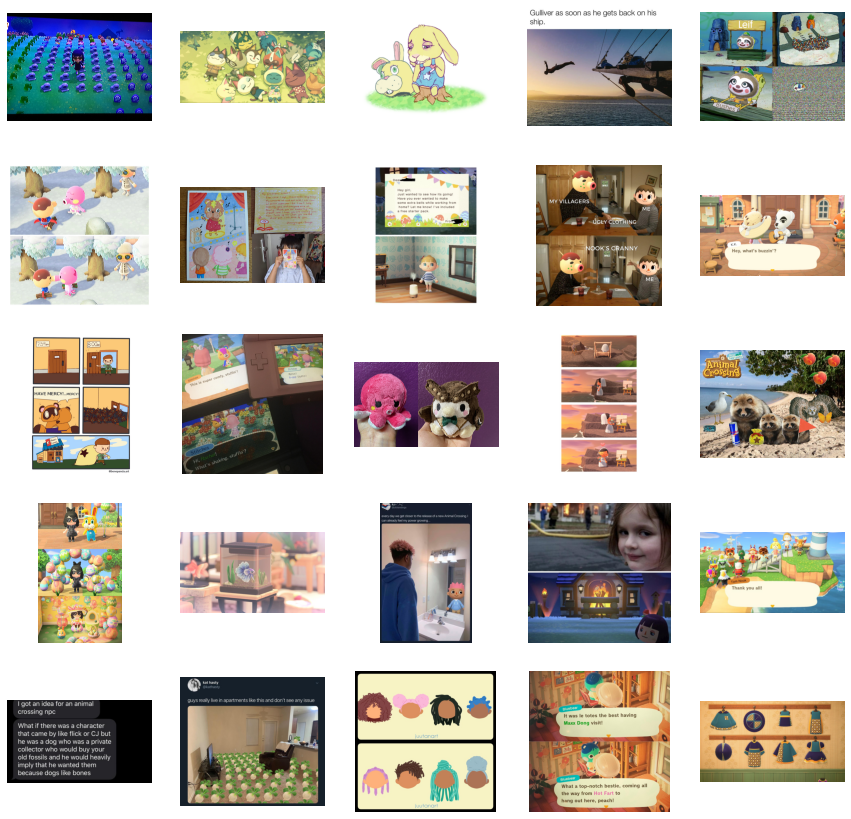

In [11]:
plot_images(ac_subset, True)

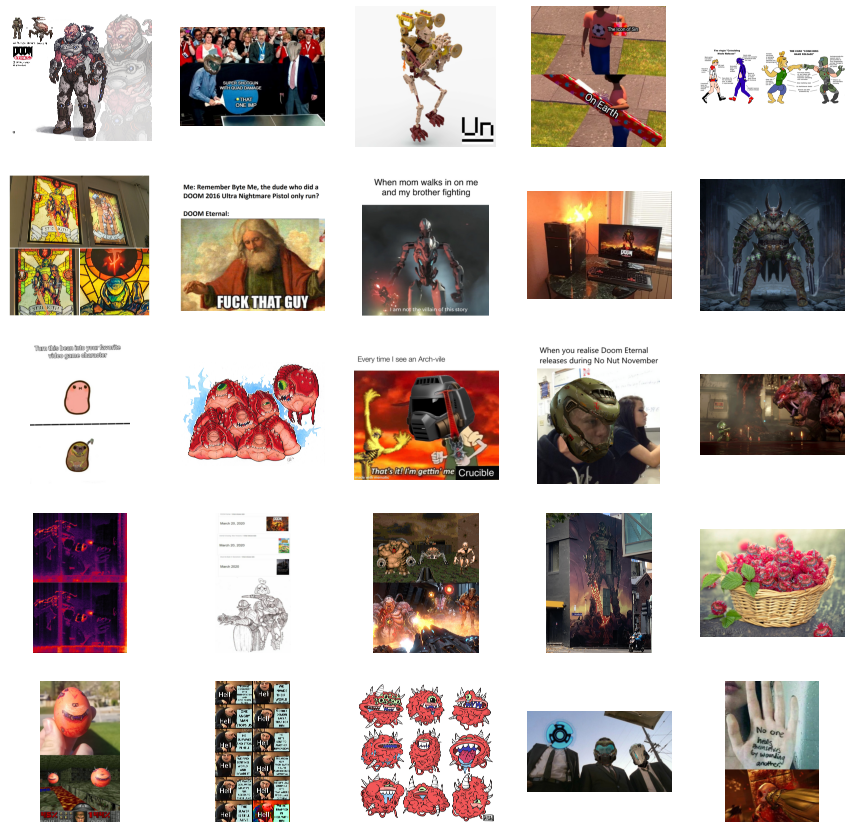

In [12]:
plot_images(doom_subset, False)

### Analysis:

These images are taken from respective subreddits from animal crossing and doom eternal (r/doom and r/animalcrossing). This means that the datasets not only include screenshots of both games, but also memes that may contain little to no assets related to either game in the image.

Some images are only text, which is more difficult to classify.

Some memes formats are used on both subreddits.

Some memes about Animal Crossing include refrences to Doom and vice versa, which can make classification difficult.

# Neural Network (Keras)

Since I was not given a train and test set of images from the Kaggle source, I made my own from the directory of images. In total, the 'animal_crossing' and 'doom' image datasets contained a combined 1,680 images. I decided to take 1000 images in total for the train sets, and the remaining 597 images for the test set. This left me with the following number of images in each set:


**train**

ac- 459 images

doom- 541 images


**test**

ac- 298 images

doom- 299 images

<br />

*code source* https://www.geeksforgeeks.org/python-image-classification-using-keras/

In [111]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.layers.normalization import BatchNormalization

img_width, img_height = 800, 800 # chosen image dimensions of 800x800

In [77]:
train_data_dir = 'archive/train'
validation_data_dir = 'archive/test'
nb_train_samples =1000 
nb_validation_samples = 597
epochs = 10
batch_size = 16

In [24]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [25]:
model = Sequential()
model.add(Conv2D(32, (2, 2), input_shape=input_shape)) # Conv2D is the layer to convolve the image into multiple images
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # MaxPooling2D is used to max pool the value from the given size matrix and same is used for the next 2 layers. then, Flatten is used below to flatten the dimensions of the image obtained after convolving it.
  
model.add(Conv2D(32, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
  
model.add(Conv2D(64, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
  
model.add(Flatten())
model.add(Dense(64)) # Dense is used to make this a fully connected model and is the hidden layer.
model.add(Activation('relu'))
model.add(Dropout(0.5)) # Dropout is used to avoid overfitting on the dataset.
model.add(Dense(1)) # Dense is the output layer contains only one neuron which decide to which category image belongs.
model.add(Activation('sigmoid'))

In [26]:
# Compile function is used here that involve use of loss, optimizers and metrics.here loss function used is binary_crossentropy, optimizer used is rmsprop.
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [27]:
train_datagen = ImageDataGenerator( #ImageDataGenerator rescales the image, applies shear in some range, zooms the image and does horizontal flipping with the image. This ImageDataGenerator includes all possible orientation of the image.
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
  
test_datagen = ImageDataGenerator(rescale=1. / 255)
  
train_generator = train_datagen.flow_from_directory( # train_datagen.flow_from_directory is the function that is used to prepare data from the train_dataset directory Target_size specifies the target size of the image.
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')
  
validation_generator = test_datagen.flow_from_directory( # test_datagen.flow_from_directory is used to prepare test data for the model and all is similar as above.
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')
  
model.fit_generator( # fit_generator is used to fit the data into the model made above, other factors used are steps_per_epochs tells us about the number of times the model will execute for the training data.
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator, # validation_data is used to feed the validation/test data into the model.
    validation_steps=nb_validation_samples // batch_size) # validation_steps denotes the number of validation/test samples.

Found 1000 images belonging to 2 classes.
Found 597 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 182s 3s/step - loss: 13.8641 - accuracy: 0.5895 - val_loss: 0.6195 - val_accuracy: 0.6537
Epoch 2/10
62/62 [==============================] - 180s 3s/step - loss: 0.6180 - accuracy: 0.6645 - val_loss: 0.5745 - val_accuracy: 0.7297
Epoch 3/10
62/62 [==============================] - 180s 3s/step - loss: 0.6186 - accuracy: 0.6393 - val_loss: 0.6596 - val_accuracy: 0.6385
Epoch 4/10
62/62 [==============================] - 180s 3s/step - loss: 0.5925 - accuracy: 0.7224 - val_loss: 0.5788 - val_accuracy: 0.7010
Epoch 5/10
62/62 [==============================] - 179s 3s/step - loss: 0.6107 - accuracy: 0.7402 - val_loss: 0.5802 - val_accuracy: 0.7365
Epoch 6/10
62/62 [==============================] - 182s 3s/step - loss: 0.5699 - accuracy: 0.7420 - val_loss: 0.6232 - val_accuracy: 0.7145
Epoch 7/10
62/62 [==============================] - 186s 3s/step - los

### Analysis:

The Keras model was successful. Using 10 epochs, took about 30 minutes to run the model to a point where the accuracy was about 78%. That is an increase in 20% accuracy from epoch 1 to epoch 10. I believe the accuracy would continue to increase if I added more epochs. Neural network models are the model I predict will be the most successful when classifying images.

# Neural Network (Pytorch)

In [95]:
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F #contains useful activation functions
import torchvision.transforms as transforms #for basic image transformations

from torch.utils.data import Dataset, DataLoader #PyTorch's data loading utility
from sklearn.model_selection import train_test_split

In [96]:
labels = data[['subreddit', 'filename']]
labels['subreddit'] = labels.subreddit.replace(to_replace=['AnimalCrossing', 'Doom'], value=[0, 1]) # Converting 'subreddit' column to 0 and 1 instead of 'AnimalCrossing' and 'Doom' in order to train the model using numerical values.
labels.head

<ipython-input-96-e0e38685b54e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['subreddit'] = labels.subreddit.replace(to_replace=['AnimalCrossing', 'Doom'], value=[0, 1]) # Converting 'subreddit' column to 0 and 1 instead of 'AnimalCrossing' and 'Doom' in order to train the model using numerical values.


<bound method NDFrame.head of      subreddit           filename
0            0  yjrafuspulu41.png
1            0  2ehmq0fjpj051.jpg
2            0  a2vvzng7g7v41.jpg
3            0  t88z1sn736x41.jpg
4            0  176wf6duetq41.jpg
..         ...                ...
834          1  psusjw84imo41.jpg
835          1  1vinuy2dhxs31.png
836          1  3jez3vw7q2r41.png
837          1  lpibxuw4kof11.png
838          1  180mf4lt79l31.jpg

[1596 rows x 2 columns]>

In [97]:
train_path = 'archive/train'
test_path = 'archive/test'

### Image Pre-processing

Using PyTorch to classify images requires the images to be transformed into tensors in order to train the model. Here the images from the dataset are standardized in pixel intensity and dimensions and transformed into tensors.

<br />

*Code source:* https://www.pluralsight.com/guides/image-classification-with-pytorch

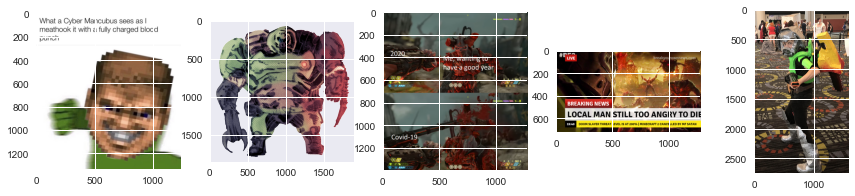

In [108]:
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(labels[labels['subreddit'] == 1]['filename'][-5:]):
    path = os.path.join(train_path,idx)
    ax[i].imshow(mpimg.imread(path))

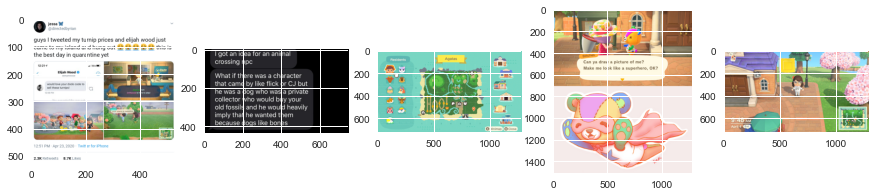

In [109]:
fig,ax = plt.subplots(1,5,figsize = (15,3))
for i,idx in enumerate(labels[labels['subreddit'] == 0]['filename'][:5]):
    path = os.path.join(train_path,idx)
    ax[i].imshow(mpimg.imread(path))

In [100]:
def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [101]:
class ACorDoomDataset(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_name,label = self.data[index]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [102]:
# Normalizing the images for faster and more stable training.
means = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(means,std)])

test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(means,std)])

valid_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(means,std)])

In [103]:
train, valid_data = train_test_split(labels, stratify=labels.subreddit, test_size=0.2)


In [104]:
train_data = ACorDoomDataset(train, train_path, train_transform )
valid_data = ACorDoomDataset(valid_data, train_path, valid_transform )
test_data = ACorDoomDataset(labels, test_path, test_transform )

In [105]:
num_epochs = 10
num_classes = 2
batch_size = 25
learning_rate = 0.001

In [106]:
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle=False, num_workers=0)

In [107]:
def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [89]:
trainimages, trainlabels = next(iter(train_loader))

fig, axes = plt.subplots(figsize=(12, 12), ncols=5)
print('training images')
for i in range(5):
    axe1 = axes[i] 
    imshow(trainimages[i], ax=axe1, normalize=False)

print(trainimages[0].size())

TypeError: join() argument must be str, bytes, or os.PathLike object, not 'int'

In [90]:
class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(720, 1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [91]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=720, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)


In [92]:
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

TypeError: join() argument must be str, bytes, or os.PathLike object, not 'int'

### Analysis:

My Pytorch model was not successful. I was interested to see how it compared to the other neural network model, Keras, however it was much harder to implement. I found a solution online (cited above), that helped me attempt to use a Pytorch model, however my attempts were unsuccessful. In theory, Pytorch should outperform the Keras model in either accuracy or speed.

# XGBoost

Once again, I split the given dataset into training and testing datasets using the same method as before resulting in datasets as follows:

**train**

ac- 459 images

doom- 541 images


**test**

ac- 298 images

doom- 299 images

<br />


*source:* https://youtu.be/2miw-69Xb0g

In [3]:
import glob
from keras.applications.vgg16 import VGG16

In [9]:
size = 256

#Initialize lists to capture training data/labels
train_images = []
train_labels = []

for directory_path in glob.glob("archive/train/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size, size)) #using open cv2 to resize images 
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #and change the color from BGR to RGB
        train_images.append(img)
        train_labels.append(label)

ing\tezpldyxa1x41.jpg
archive/train\animal_crossing\thm0z4ykvss41.jpg
archive/train\animal_crossing\thqiug0b5a051.jpg
archive/train\animal_crossing\tiw9kuhlwlx41.jpg
archive/train\animal_crossing\tlkrdcjx5tp41.jpg
archive/train\animal_crossing\tmjnrzx5ncx41.jpg
archive/train\animal_crossing\TnKxDqh.jpg
archive/train\animal_crossing\tQxPq0Q.jpg
archive/train\animal_crossing\tvodupn3e0s41.jpg
archive/train\animal_crossing\u1caidls78v41.jpg
archive/train\animal_crossing\u3azew2uyxy41.jpg
archive/train\animal_crossing\ubyghe0ue7t41.jpg
archive/train\animal_crossing\ufmdogx78lx41.jpg
archive/train\animal_crossing\uhjr138rb2p41.jpg
archive/train\animal_crossing\ujg0iwdhdyw41.jpg
archive/train\animal_crossing\ULAJ543.jpg
archive/train\animal_crossing\uowc5th2kht41.jpg
archive/train\animal_crossing\uqlg2mzz7lt41.jpg
archive/train\animal_crossing\uqnqeu1rfxo41.jpg
archive/train\animal_crossing\ut4dpd5d51x41.jpg
archive/train\animal_crossing\ux7q18g45lx41.jpg
archive/train\animal_crossing\uxern5

In [18]:
#convert lists to arrays (easier to work with)
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [19]:
#repeating the steps above, this time for the training data

#Initialize lists to capture testing data/labels
test_images = []
test_labels = []

for directory_path in glob.glob("archive/test/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size, size)) #using open cv2 to resize images 
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #and change the color from BGR to RGB
        test_images.append(img)
        test_labels.append(label)

r41.jpg
archive/test\animal_crossing\0mzs9f0wb8z41.jpg
archive/test\animal_crossing\0ozodkocirw41.jpg
archive/test\animal_crossing\0wovk4f2v0h41.jpg
archive/test\animal_crossing\0yotitpwxht41.jpg
archive/test\animal_crossing\1be6ge0vqrx41.jpg
archive/test\animal_crossing\1hvci9xecgm41.jpg
archive/test\animal_crossing\1if48k12e1q41.jpg
archive/test\animal_crossing\1iydjh1w9xz41.jpg
archive/test\animal_crossing\1jsic9i2wmu41.jpg
archive/test\animal_crossing\1kool8vkq0r41.jpg
archive/test\animal_crossing\1m4kgui15us41.jpg
archive/test\animal_crossing\1mau9ybffiq41.jpg
archive/test\animal_crossing\1nj60xs06y151.jpg
archive/test\animal_crossing\1ppdvul5ll051.jpg
archive/test\animal_crossing\1qcffna4czr41.jpg
archive/test\animal_crossing\1vy8abm.jpg
archive/test\animal_crossing\2c0drcqw07151.jpg
archive/test\animal_crossing\2eet6z805a251.jpg
archive/test\animal_crossing\2ehmq0fjpj051.jpg
archive/test\animal_crossing\2g1c09whuqq41.jpg
archive/test\animal_crossing\2ir6nzse8tt41.jpg
archive/tes

In [20]:
#convert lists to arrays (easier to work with)
test_images = np.array(train_images)
test_labels = np.array(train_labels)

In [21]:
#encode labels from string to integers
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [22]:
#copying data into new variables. These variable are labeled more accuratly for model training and will make the next steps easier to comprehend.
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [23]:
#rescaling pixel values between 0 and 1. (normalizing)
x_train, x_test = x_train / 255.0, x_test / 255.0

In [24]:
#importing VGG model
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(size, size, 3))

In [25]:
#Make loaded layers as non-trainable, allowing us to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False

In [26]:
#Extracting features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)

In [27]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features #This is our X input to RF

In [28]:
import xgboost as xgb

model = xgb.XGBClassifier()
model.fit(X_for_training, y_train)

C:\Users\Charlie\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[20:18:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
#Extracting features from testing data
X_test_feature = VGG_model.predict(x_test)

In [30]:
#reshaping
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [31]:
#Now predict using the trained RF model. 
prediction = model.predict(X_test_features)
#Inverse le transform to get original text labels back (AnimalCrossing and Doom, rather than 0 or 1). 
prediction = le.inverse_transform(prediction)

In [32]:
print ("Accuracy = ", accuracy_score(test_labels, prediction))

Accuracy =  1.0


<AxesSubplot:>

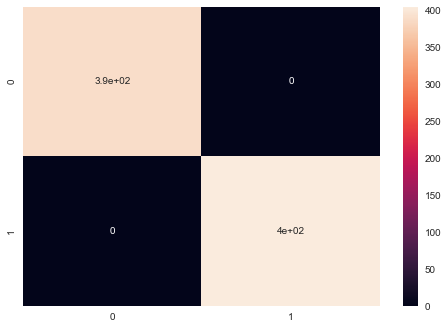

In [33]:
#creating and displaying a confusion matrix
cm = confusion_matrix(test_labels, prediction)
sns.heatmap(cm, annot=True)

The prediction for this image is:  ['animal_crossing']
The actual label for this image is:  animal_crossing


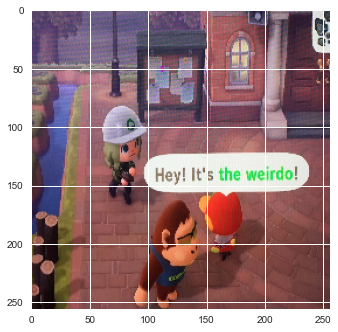

In [76]:
#Check results on a few select images. 
#EACH TIME THIS BLOCK IS RUN, A NEW IMAGE, PREDICTED LABEL, AND ACTUAL LABEL IS DISPLAYED

n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction = model.predict(input_img_features)[0] 
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

### Analysis:

To my suprise, the XGBoost model resulted in 100% accuracy. After running a confusion matrix, and a simple test that displays a random image, the predicted value, and the actual value, everything checks out. I do not believe it is actually realistic that a model can classify images with 100% accuracy, so something in the way the data was prepared for feature extraction must not be correct, hoewever I can't figure out what it is. 

# Decision Tree Classification

*source code:* https://www.datacamp.com/community/tutorials/decision-tree-classification-python

In [4]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [5]:
size = 256

#Initialize lists to capture training data/labels
train_images = []
train_labels = []

for directory_path in glob.glob("archive/train/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size, size)) #using open cv2 to resize images 
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #and change the color from BGR to RGB
        train_images.append(img)
        train_labels.append(label)

ing\tezpldyxa1x41.jpg
archive/train\animal_crossing\thm0z4ykvss41.jpg
archive/train\animal_crossing\thqiug0b5a051.jpg
archive/train\animal_crossing\tiw9kuhlwlx41.jpg
archive/train\animal_crossing\tlkrdcjx5tp41.jpg
archive/train\animal_crossing\tmjnrzx5ncx41.jpg
archive/train\animal_crossing\TnKxDqh.jpg
archive/train\animal_crossing\tQxPq0Q.jpg
archive/train\animal_crossing\tvodupn3e0s41.jpg
archive/train\animal_crossing\u1caidls78v41.jpg
archive/train\animal_crossing\u3azew2uyxy41.jpg
archive/train\animal_crossing\ubyghe0ue7t41.jpg
archive/train\animal_crossing\ufmdogx78lx41.jpg
archive/train\animal_crossing\uhjr138rb2p41.jpg
archive/train\animal_crossing\ujg0iwdhdyw41.jpg
archive/train\animal_crossing\ULAJ543.jpg
archive/train\animal_crossing\uowc5th2kht41.jpg
archive/train\animal_crossing\uqlg2mzz7lt41.jpg
archive/train\animal_crossing\uqnqeu1rfxo41.jpg
archive/train\animal_crossing\ut4dpd5d51x41.jpg
archive/train\animal_crossing\ux7q18g45lx41.jpg
archive/train\animal_crossing\uxern5

In [6]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [7]:
#repeating the steps above, this time for the training data

#Initialize lists to capture testing data/labels
test_images = []
test_labels = []

for directory_path in glob.glob("archive/test/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size, size)) #using open cv2 to resize images 
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #and change the color from BGR to RGB
        test_images.append(img)
        test_labels.append(label)

r41.jpg
archive/test\animal_crossing\0mzs9f0wb8z41.jpg
archive/test\animal_crossing\0ozodkocirw41.jpg
archive/test\animal_crossing\0wovk4f2v0h41.jpg
archive/test\animal_crossing\0yotitpwxht41.jpg
archive/test\animal_crossing\1be6ge0vqrx41.jpg
archive/test\animal_crossing\1hvci9xecgm41.jpg
archive/test\animal_crossing\1if48k12e1q41.jpg
archive/test\animal_crossing\1iydjh1w9xz41.jpg
archive/test\animal_crossing\1jsic9i2wmu41.jpg
archive/test\animal_crossing\1kool8vkq0r41.jpg
archive/test\animal_crossing\1m4kgui15us41.jpg
archive/test\animal_crossing\1mau9ybffiq41.jpg
archive/test\animal_crossing\1nj60xs06y151.jpg
archive/test\animal_crossing\1ppdvul5ll051.jpg
archive/test\animal_crossing\1qcffna4czr41.jpg
archive/test\animal_crossing\1vy8abm.jpg
archive/test\animal_crossing\2c0drcqw07151.jpg
archive/test\animal_crossing\2eet6z805a251.jpg
archive/test\animal_crossing\2ehmq0fjpj051.jpg
archive/test\animal_crossing\2g1c09whuqq41.jpg
archive/test\animal_crossing\2ir6nzse8tt41.jpg
archive/tes

In [8]:
#convert lists to arrays (easier to work with)
test_images = np.array(train_images)
test_labels = np.array(train_labels)

In [9]:
#encode labels from string to integers
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [10]:
#copying data into new variables. These variable are labeled more accuratly for model training and will make the next steps easier to comprehend.
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [11]:
#4D array
x_test.shape

(795, 256, 256, 3)

In [12]:
#4D array
x_train.shape

(795, 256, 256, 3)

In [13]:
#currently, the input data is 4-dimensional. The data needs to be flattened into 2 dimensions.
# source: https://stackoverflow.com/questions/57187680/how-to-resolve-valueerror-found-array-with-dim-4-estimator-expected-2
x_train = x_train.reshape(795,3*256*256)
x_test = x_test.reshape(795,3*256*256)

In [14]:
#rescaling pixel values between 0 and 1. (normalizing)
#x_train, x_test = x_train / 255.0, x_test / 255.0

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(x_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(x_test)

In [15]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


### Analysis:

classification rate of 100%, which does not seem possible! I used the same method of creating and formatting input data as I did when I ran the XGBoost model (which also got 100% accuracy), leading me to believe that there is some sort of flaw with data input. Whether it be mis-classification or some sort of give away within the data as to what category an image belongs to.

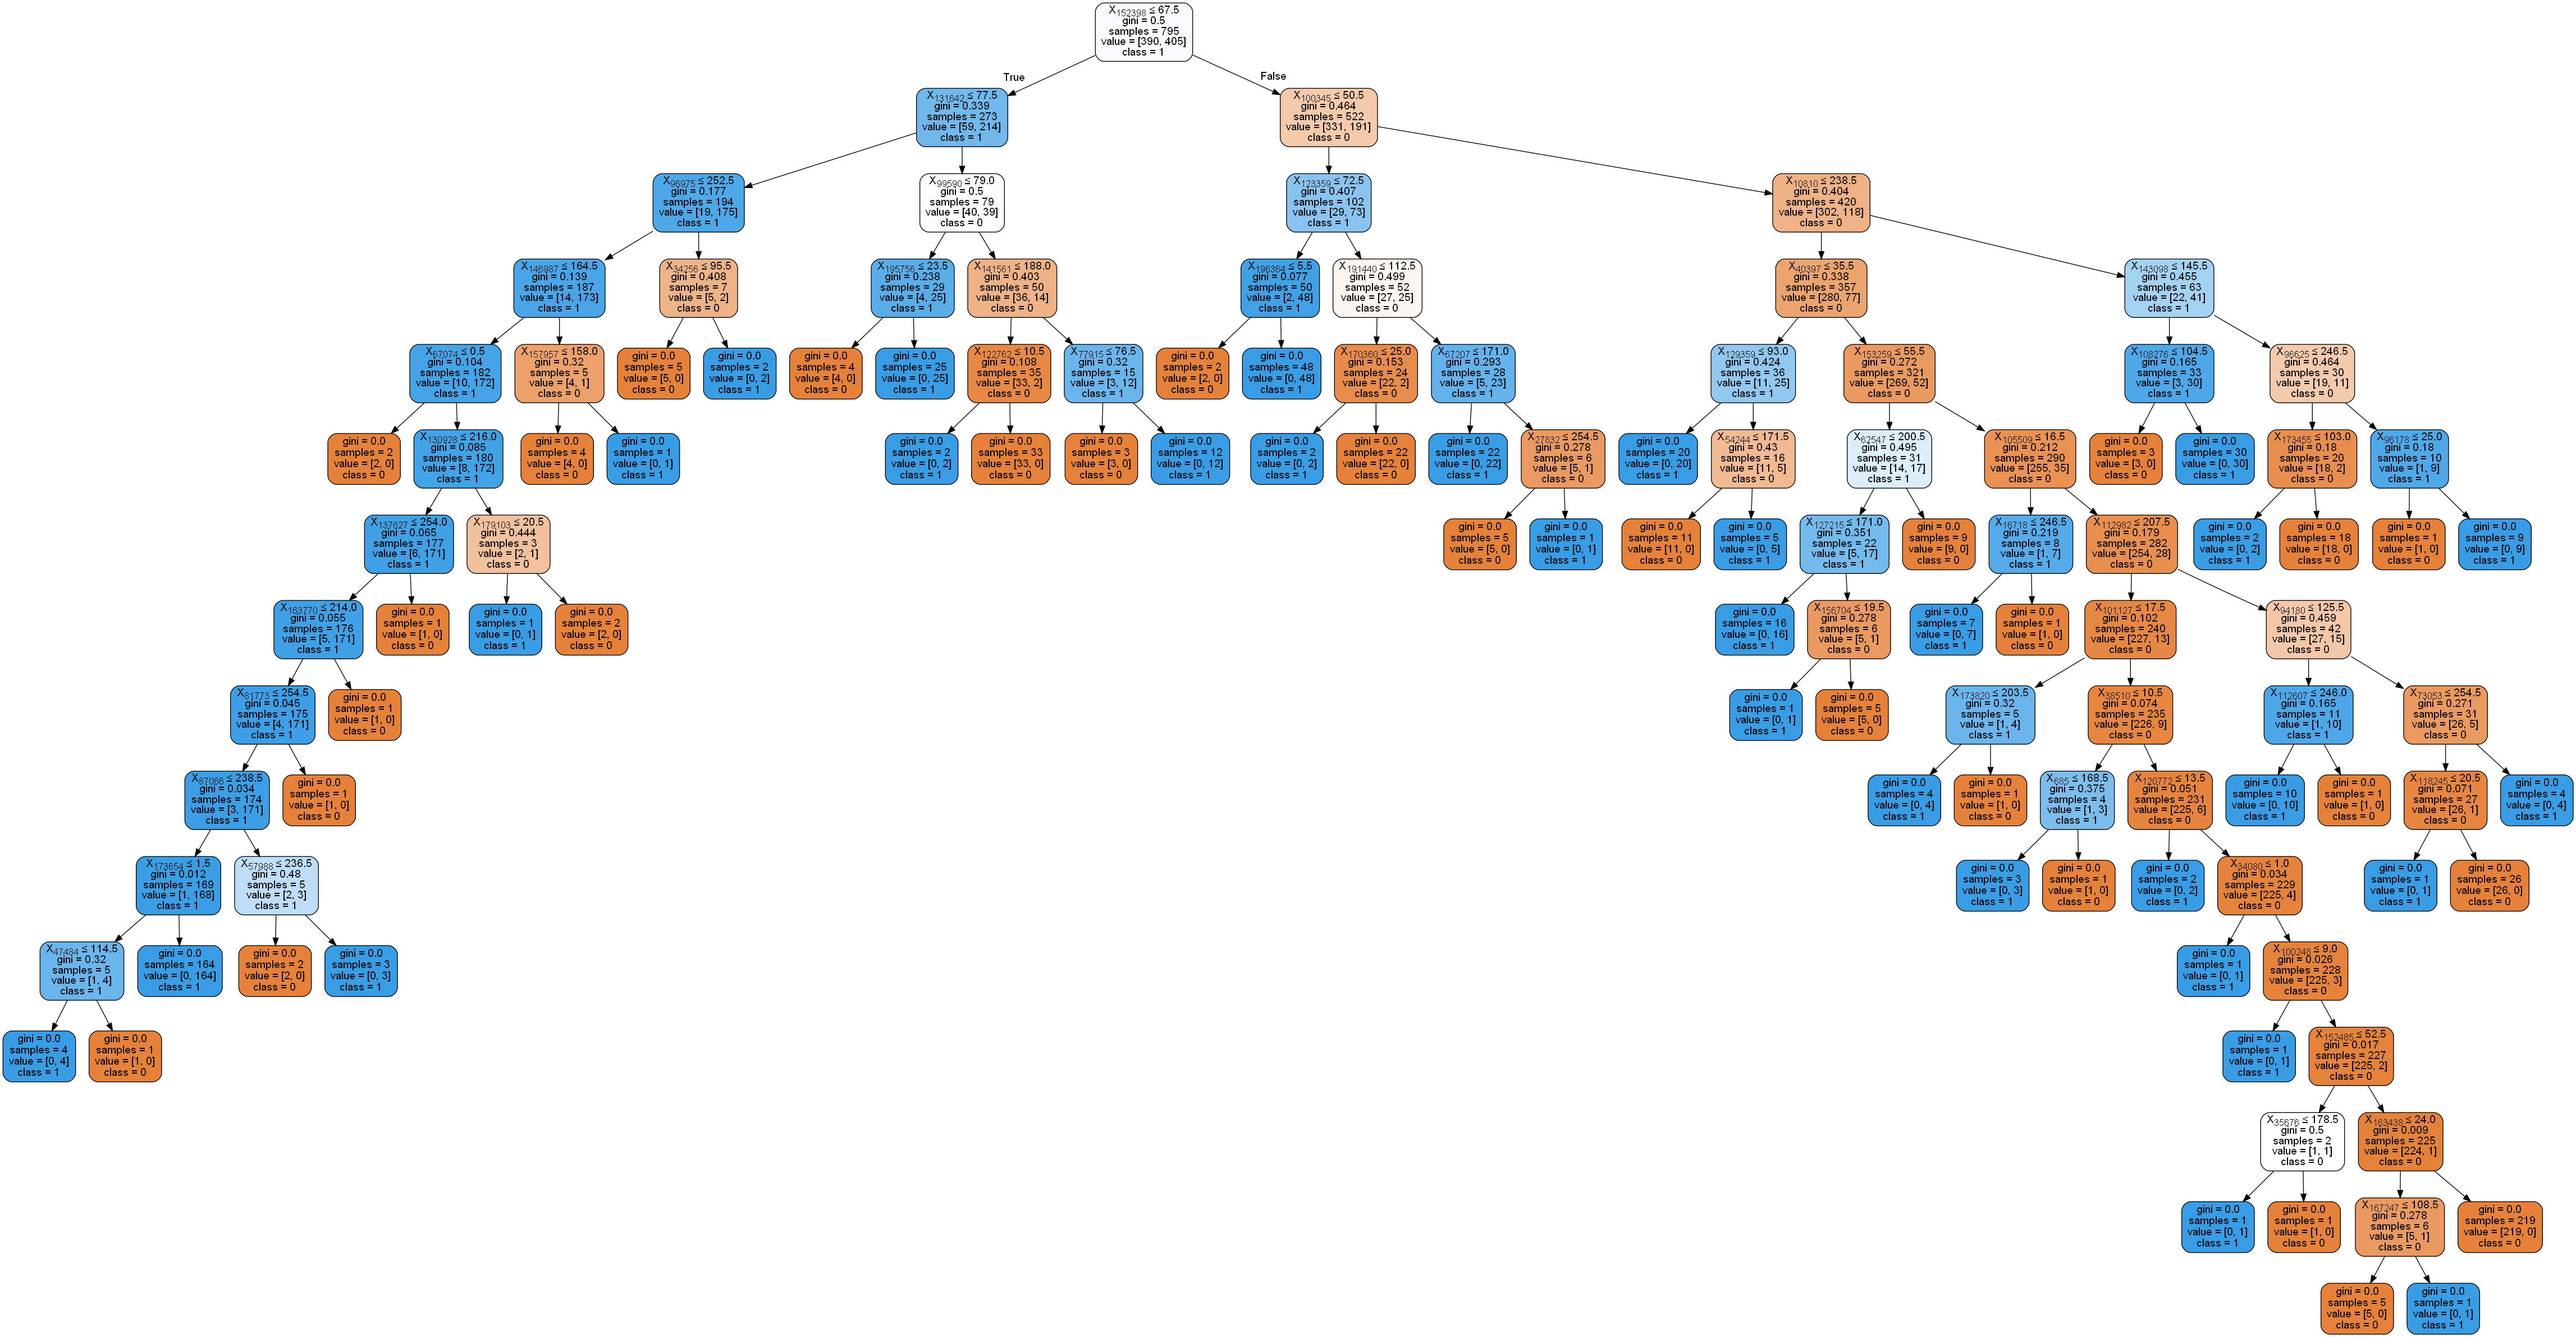

In [16]:
from sklearn.tree import export_graphviz
#from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from six import StringIO

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names=None,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('ACorDOOMtree.png')
Image(graph.create_png())

# Logistic Regression

Since this project is about image classification, I decided that logistic regression was not a good fit. When using regression, the output variable is expected to be a continuous numerical value. With that being said, log regression is used for solving classification problems despite being a form of regression. With log regression, the target variable becomes categorical since it will have a binary output (classified as either 0 or 1). Using the Sigmoid function (which has values both very close to 0 and very close to 1 on the 'S'-shaped line), a model can predict whether or not an input is 0 or 1 depending on the threshold that is determined. 

Logisitc regression is no the best fit for this project simply because neural networks are so much better for image classification. In a sense, log regression is basically a single-layer neural network. With that in mind, log regression would make for a similar, but less accurate CNN model.

# Conclusion

Overall, between all of the successful methods, XGBoost and the decision tree classification were the most accurate. With that being said, both of those methods had an accuracy of 100% which is a bit unrealistic to me, leading me to believe that there was some underlying data that gave away the correct label for any given image. If I had more time, I would try and figure out what might be causing the accuracy to be so high. Lastly, the keras neural network reached an accuracy of about 78% which seemed much more realistic. The data input method for keras was much more straight foward, and much easier to implement leaving me with less room for error and possibly giving me support for my claim that the other 2 successful methods had some sort of fault during data input. The keras neural network also took the longest time to complete at around 30 minutes for 10 epochs, and given more time to train the model on more epochs, the accuracy would have increased.